In [1]:
import torch
import functools
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from tqdm import tqdm
import argparse
from argparse import Namespace


In [2]:
import sys 
sys.path.append('/groups/kexin/GitHub/DDPM/')
from ddpm import script_utils, unet, diffusion, utils

In [3]:
sigma =  25.0#@param {'type':'number'}

marginal_prob_std_fn = functools.partial(utils.marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(utils.diffusion_coeff, sigma=sigma)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

defaults = dict(num_images=10, device=device, model_path="/groups/kexin/GitHub/DDPM/ddpm_logs/ckpt_score_based_model.pth", save_dir="results/")
defaults.update(script_utils.diffusion_defaults())
args = Namespace(**defaults)
args

Namespace(activation='silu', channels=[32, 64, 128, 256], device=device(type='cuda'), dropout=0.1, ema_decay=0.9999, ema_update_rate=1, loss_type='l2', model_path='/groups/kexin/GitHub/DDPM/ddpm_logs/ckpt_score_based_model.pth', norm='gn', num_images=10, num_res_blocks=1, num_timesteps=100, save_dir='results/', schedule='linear', schedule_high=0.02, schedule_low=0.0001, time_emb_dim=128, use_labels=True)

In [9]:
args.model_path

'/groups/kexin/GitHub/DDPM/ddpm_logs/ckpt_score_based_model.pth'

In [10]:
# Load the pre-trained checkpoint from disk.
diffusion = script_utils.get_diffusion_from_args(args).to(device)
diffusion.load_state_dict(torch.load(args.model_path))

<All keys matched successfully>

100%|██████████| 200/200 [00:00<00:00, 500.39it/s]


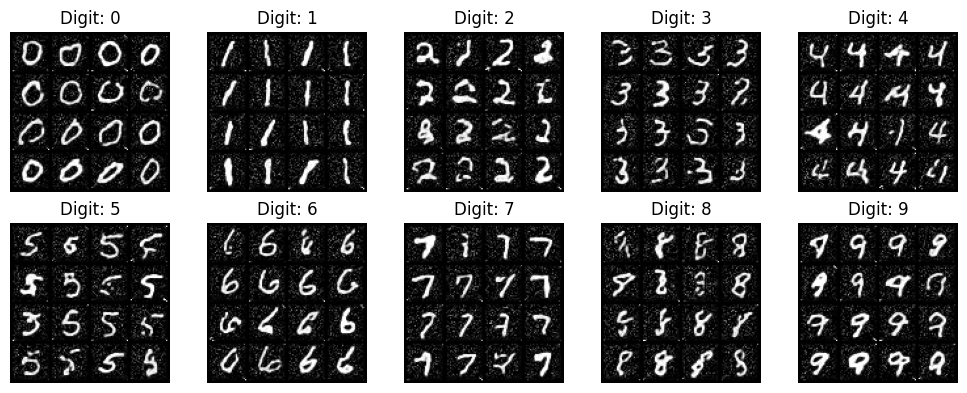

In [15]:

# Load the pre-trained checkpoint from disk.
diffusion.eval()

# Set params
sample_batch_size = 16 #@param {'type':'integer'}
num_steps = 200 #@param {'type':'integer'}

## Generate samples using the specified sampler.
%matplotlib inline
plt.figure(figsize=(10, 4))

for i, digit in enumerate(range(10)):
    samples = diffusion.sample_score_based_model(marginal_prob_std_fn, diffusion_coeff_fn, num_steps, sample_batch_size, device=device, y=digit*torch.ones(sample_batch_size, dtype=torch.long).to(device))
    
    ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.subplot(2, 5, i+1)
    plt.title(f"Digit: {digit}")
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)

plt.tight_layout()
plt.show()